In [1]:
# Importing Packages

# Dataframes
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Splitting data
from sklearn.model_selection import train_test_split

# Text Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

# Reports
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Resampling
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Parameter Tuning
from sklearn.model_selection import GridSearchCV

# Bagging
from sklearn.ensemble import BaggingClassifier

# Boosting
from sklearn.ensemble import AdaBoostClassifier

# Data Preparations

## Retrieve the Data

In [2]:
# Retrieve dataset
df = pd.read_csv("input_new_categories.csv")

# Drop nulls
df = df.dropna()

## Split the Data

In [3]:
# Clarify independent and dependent variables
x = df['text']
y = df['type']

# Split datasets into training and testing sets
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.2, random_state = 0)

# Export ytest for validations in R
ytest.to_csv('ytest.csv', index=False)

## Text Vectorization and Conversion to Dataframes
One cannot filter to relevant terms unless they convert the X datasets to dataframes.

In [4]:
# Define vectorizer
vectorizer = TfidfVectorizer()

# Vectorize xtrain
vector_xtrain = vectorizer.fit_transform(xtrain)

# Store xtrain feature names
feats_xtr = vectorizer.get_feature_names_out()

# Vectorize xtest
vector_xtest = vectorizer.transform(xtest)

# Store xtest feature names
feats_xte = vectorizer.get_feature_names_out()

# Create dataframes of xtrain and xtest
vector_xtr = pd.DataFrame.sparse.from_spmatrix(vector_xtrain, columns = feats_xtr)
vector_xte = pd.DataFrame.sparse.from_spmatrix(vector_xtest, columns = feats_xte)

# Convert xtrain and xtest to dense values
vector_xtr = vector_xtr.sparse.to_dense().astype(np.float64)
vector_xte = vector_xte.sparse.to_dense().astype(np.float64)

## Filtering to Relevant Features

In [5]:
# Retrieve word importance list
word_importance = pd.read_excel('word_importance_lists.xlsx')

# Create list of top x words
words = list(word_importance['Word'].head(100))

# Create list of xtrain columns
xtrain_cols = list(vector_xtr.columns)

# Create set of xtrain words
xtrain_set = set(words) & set(xtrain_cols)

# Convert set to list
xtrain_list = list(xtrain_set)

# Create list of xtest columns
xtest_cols = list(vector_xte.columns)

# Create set of xtest words
xtest_set = set(words) & set(xtest_cols)

# Convert set to list
xtest_list = list(xtest_set)

# Filter xtrain and xtest to relevant columns
vector_xtrain = vector_xtr[xtrain_list]
vector_xtest = vector_xte[xtest_list]

## Sampling Adjustments

In [6]:
# Create Oversampled Datasets
overs = RandomOverSampler(random_state = 0)
vector_xtrain_os, ytrain_os = overs.fit_resample(vector_xtrain, ytrain)

# Create Undersampled Datasets
unders = RandomUnderSampler(random_state = 0)
vector_xtrain_us, ytrain_us = unders.fit_resample(vector_xtrain, ytrain)

## Create Labels List

In [7]:
# Create a "labels" list
labels = ['database', 'database_admin', 'deploy', 'elasticsearch', 'fastly', 'redis', 'resources', 'sendgrid', 'upgrade_services', 'upsize']

# Models

## Classification Tree (Sharath)
Parameters
* criterion (default 'gini'): function used to measure split quality. can be 'gini', 'entropy', or 'log_loss'
* splitter (default 'best'): strategy used to choose the split at each node. can be 'best' [choose best split] or 'random' [choose best random split]
* max_depth (default None): maximum depth of the tree; int
* min_samples_split (default 2): minimum samples required to split a node; int or float [float works like a fraction; n_samples*\min_samples_split = min_samples_split input)]
* min_samples_leaf (default 1): minimum saples required at a leaf node; int or float [float works like min_samples_split]
* min_weight_fraction_leaf (default 0.0): minimum weighted fract of sum of total weights of input samples required at a leaf node
* max_features (default None): # of features to consider when looking at best split. can be int, float, sqrt, log2, or None [# of features, fract of features, sqrt of features, log2 of features, all features]
* random_state (default None): controls randomness of the estimator; int
* max_leaf_nodes (default None): define max number of leaf nodes; int
* min_impurity_decrease (default 0.0): node splits if it's impurity decrease is >= this value; float
* class_weight (default None): weights assigned to classes. If 'None', all classees weighed equally
* ccp_alpha (default 0.0): complexity parameter used for minimal cost-complexity pruning [subtree with largest cost complexity that is smaller than ccp_alpha is chosen]; default means no pruning; float
* monotonic_cst: NON-APPLICABLE

In [11]:
# Classification Tree
from sklearn.tree import DecisionTreeClassifier

### Non-Ensemble Parameter Testing

In [ ]:
# Define relevant parameters to test
parameter_space = {'max_depth':,
                   'min_samples_split':,
                   'min_impurity_decrease':,
                   'random_state': 0}

# Clarify model
mdl = DecisionTreeClassifier()

# Place model and parameters into GSCV
clf = GridSearchCV(mdl, parameter_space, n_jobs=-1, cv=5)

# Fit GSCV
clf.fit(vector_xtrain, ytrain)

# Produce best accuracy and parameters
print(f'Score: {clf.best_score_}')
print(f'Parameters: {clf.best_params_}')

### Non-Ensemble Model

In [48]:
%%time
# Define the model and internal parameters
mdl = DecisionTreeClassifier(random_state=0)

# Train the model
mdl.fit(vector_xtrain_us, ytrain_us)

CPU times: total: 359 ms
Wall time: 623 ms


DecisionTreeClassifier(random_state=0)

In [49]:
%%time
# Predict dependent variable for testing data
preds = mdl.predict(vector_xtest)

CPU times: total: 0 ns
Wall time: 3.99 ms


In [50]:
# Store and export predictions
preds2 = pd.DataFrame(preds)
preds2.to_csv('ct_preds_us.csv', index=False)

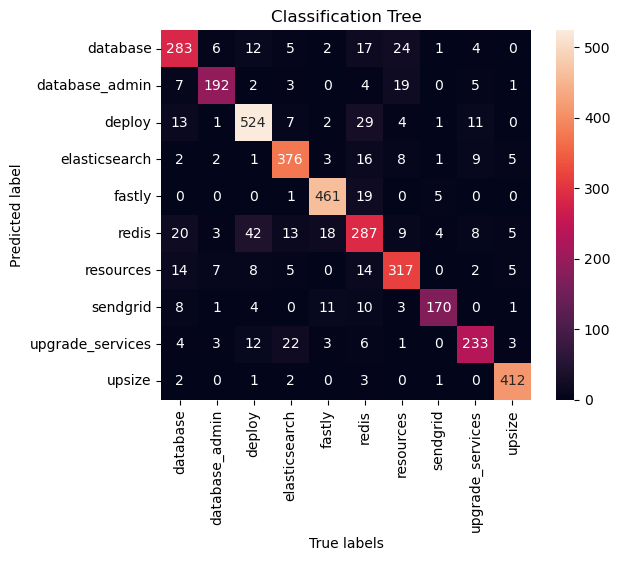

In [51]:
# Plot a confusion matrix
mat = confusion_matrix(ytest, preds)
sns.heatmap(mat.T, square = True, annot=True, fmt = "d", xticklabels=labels,yticklabels=labels)
plt.title('Classification Tree')
plt.xlabel("True labels")
plt.ylabel("Predicted label")
plt.show()

In [52]:
# Generate a classification report
print('Classification Tree, Test')
print(classification_report(ytest, preds))

Classification Tree, Test
                  precision    recall  f1-score   support

        database       0.80      0.80      0.80       353
  database_admin       0.82      0.89      0.86       215
          deploy       0.89      0.86      0.87       606
   elasticsearch       0.89      0.87      0.88       434
          fastly       0.95      0.92      0.94       500
           redis       0.70      0.71      0.71       405
       resources       0.85      0.82      0.84       385
        sendgrid       0.82      0.93      0.87       183
upgrade_services       0.81      0.86      0.83       272
          upsize       0.98      0.95      0.97       432

        accuracy                           0.86      3785
       macro avg       0.85      0.86      0.86      3785
    weighted avg       0.86      0.86      0.86      3785



In [53]:
# Predict ytrain
preds = mdl.predict(vector_xtrain_us)

# Generate a classification report
print('Classification Tree, Train')
print(classification_report(ytrain_us, preds))

Classification Tree, Train
                  precision    recall  f1-score   support

        database       1.00      1.00      1.00       747
  database_admin       1.00      1.00      1.00       747
          deploy       1.00      1.00      1.00       747
   elasticsearch       1.00      1.00      1.00       747
          fastly       1.00      1.00      1.00       747
           redis       1.00      1.00      1.00       747
       resources       1.00      1.00      1.00       747
        sendgrid       1.00      1.00      1.00       747
upgrade_services       1.00      1.00      1.00       747
          upsize       1.00      1.00      1.00       747

        accuracy                           1.00      7470
       macro avg       1.00      1.00      1.00      7470
    weighted avg       1.00      1.00      1.00      7470



### Bagging Parameter Testing

In [ ]:
# Define relevant parameters to test
parameter_space = {'n_estimators':[],
                   'random_state': 0}

# Clarify model and its internal parameters
mdl = DecisionTreeClassifier(random_state=0)

# Place bagger and parameters into GSCV
clf = GridSearchCV(BaggingClassifier(mdl),
                   parameter_space, n_jobs=-1, cv=5)

# Fit GSCV
clf.fit(vector_xtrain, ytrain)

# Produce best accuracy and parameters
print(f'Score: {clf.best_score_}')
print(f'Parameters: {clf.best_params_}')

### Bagging Model

In [54]:
%%time
# Define model and its internal parameters
mdl = DecisionTreeClassifier(random_state=0)

# Define bagger and its internal parameters
bg = BaggingClassifier(mdl,
                       random_state=0)

# Fit bagger
bg.fit(vector_xtrain_us, ytrain_us)

CPU times: total: 3.36 s
Wall time: 5.63 s


BaggingClassifier(estimator=DecisionTreeClassifier(random_state=0),
                  random_state=0)

In [55]:
%%time
# Predict
preds = bg.predict(vector_xtest)

CPU times: total: 0 ns
Wall time: 37.1 ms


In [56]:
# Store and export predictions
preds2 = pd.DataFrame(preds)
preds2.to_csv('ct_preds_bg_us.csv', index=False)

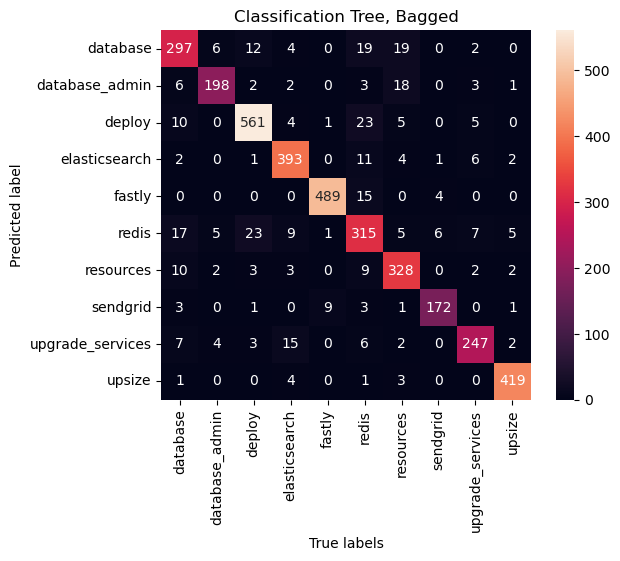

In [57]:
# Plot a confusion matrix
mat = confusion_matrix(ytest, preds)
sns.heatmap(mat.T, square = True, annot=True, fmt = "d", xticklabels=labels,yticklabels=labels)
plt.title('Classification Tree, Bagged')
plt.xlabel("True labels")
plt.ylabel("Predicted label")
plt.show()

In [58]:
# Generate a classification report
print('Classification Tree, Bagged, Test')
print(classification_report(ytest, preds))

Classification Tree, Bagged, Test
                  precision    recall  f1-score   support

        database       0.83      0.84      0.83       353
  database_admin       0.85      0.92      0.88       215
          deploy       0.92      0.93      0.92       606
   elasticsearch       0.94      0.91      0.92       434
          fastly       0.96      0.98      0.97       500
           redis       0.80      0.78      0.79       405
       resources       0.91      0.85      0.88       385
        sendgrid       0.91      0.94      0.92       183
upgrade_services       0.86      0.91      0.89       272
          upsize       0.98      0.97      0.97       432

        accuracy                           0.90      3785
       macro avg       0.90      0.90      0.90      3785
    weighted avg       0.90      0.90      0.90      3785



In [59]:
# Predict ytrain
preds = bg.predict(vector_xtrain_us)

# Generate a classification report
print('Classification Tree, Bagged, Train')
print(classification_report(ytrain_us, preds))

Classification Tree, Bagged, Train
                  precision    recall  f1-score   support

        database       0.99      1.00      0.99       747
  database_admin       1.00      0.99      0.99       747
          deploy       0.99      1.00      1.00       747
   elasticsearch       0.99      1.00      1.00       747
          fastly       0.99      1.00      0.99       747
           redis       1.00      0.98      0.99       747
       resources       1.00      1.00      1.00       747
        sendgrid       1.00      1.00      1.00       747
upgrade_services       1.00      1.00      1.00       747
          upsize       1.00      1.00      1.00       747

        accuracy                           1.00      7470
       macro avg       1.00      1.00      1.00      7470
    weighted avg       1.00      1.00      1.00      7470



### Boosting Parameter Testing

In [ ]:
# Define relevant parameters to test
parameter_space = {'n_estimators':,
                   'random_state': 0}

# Clarify model and its internal parameters
mdl = DecisionTreeClassifier(random_state=0)

# Place bagger and parameters into GSCV
clf = GridSearchCV(AdaBoostClassifier(mdl),
                   parameter_space, n_jobs=-1, cv=5)

# Fit GSCV
clf.fit(vector_xtrain, ytrain)

# Produce best accuracy and parameters
print(f'Score: {clf.best_score_}')
print(f'Parameters: {clf.best_params_}')

### Boosting Model

In [60]:
%%time
# Clarify model and its internal parameters
mdl = DecisionTreeClassifier(random_state=0)

# Define booster and its internal parameters
bs = AdaBoostClassifier(mdl,
                        random_state = 0)

# Fit booster
bs.fit(vector_xtrain_us, ytrain_us)

CPU times: total: 703 ms
Wall time: 969 ms


AdaBoostClassifier(estimator=DecisionTreeClassifier(random_state=0),
                   random_state=0)

In [61]:
%%time
# Generate predictions
preds = bs.predict(vector_xtest)

CPU times: total: 0 ns
Wall time: 6.82 ms


In [62]:
# Store and export predictions
preds2 = pd.DataFrame(preds)
preds2.to_csv('ct_preds_bs_us.csv', index=False)

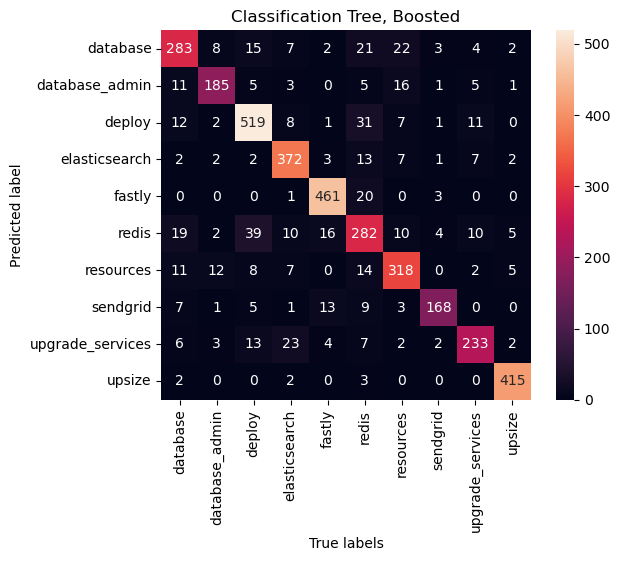

In [63]:
# Plot a confusion matrix
mat = confusion_matrix(ytest, preds)
sns.heatmap(mat.T, square = True, annot=True, fmt = "d", xticklabels=labels,yticklabels=labels)
plt.title('Classification Tree, Boosted')
plt.xlabel("True labels")
plt.ylabel("Predicted label")
plt.show()

In [64]:
# Generate a classification report
print('Classification Tree, Boosted, Test')
print(classification_report(ytest, preds))

Classification Tree, Boosted, Test
                  precision    recall  f1-score   support

        database       0.77      0.80      0.79       353
  database_admin       0.80      0.86      0.83       215
          deploy       0.88      0.86      0.87       606
   elasticsearch       0.91      0.86      0.88       434
          fastly       0.95      0.92      0.94       500
           redis       0.71      0.70      0.70       405
       resources       0.84      0.83      0.83       385
        sendgrid       0.81      0.92      0.86       183
upgrade_services       0.79      0.86      0.82       272
          upsize       0.98      0.96      0.97       432

        accuracy                           0.85      3785
       macro avg       0.84      0.86      0.85      3785
    weighted avg       0.86      0.85      0.86      3785



In [65]:
# Predict ytrain
preds = bs.predict(vector_xtrain_us)

# Generate a classification report
print('Classification Tree, Boosted, Train')
print(classification_report(ytrain_us, preds))

Classification Tree, Boosted, Train
                  precision    recall  f1-score   support

        database       1.00      1.00      1.00       747
  database_admin       1.00      1.00      1.00       747
          deploy       1.00      1.00      1.00       747
   elasticsearch       1.00      1.00      1.00       747
          fastly       1.00      1.00      1.00       747
           redis       1.00      1.00      1.00       747
       resources       1.00      1.00      1.00       747
        sendgrid       1.00      1.00      1.00       747
upgrade_services       1.00      1.00      1.00       747
          upsize       1.00      1.00      1.00       747

        accuracy                           1.00      7470
       macro avg       1.00      1.00      1.00      7470
    weighted avg       1.00      1.00      1.00      7470



## MLP Classifier (Max)
Parameters
* hidden_layer_sizes (default 100,): number of neurons in the hidden layers
* activation (default 'relu'): activation for the hidden layer; identity [no-op activation], logistic [logistic sigmoid function], tanh [hyperbolic tan function], relu [rectified linear unit function]
* solver (default 'adam'): solver for weight optimization; 'lbfgs' [quasi-Newton optimizer], 'sgd' [stochastic gradient descent], 'adam' [sgd optimizer] ADAM RECOMMENDED FOR LARGE DATASETS
* alpha (default 0.0001): strength of the L2 regularization term; float
* batch_size (default 'auto'): size of minibatches for stochastic optimizers; int, auto [batch_size = min(200, n_samples)]
* learning_rate (default 'constant'): learning rate schedule for weight updates, only applies to solver sgd; constant [constant learning rate], invscaling [gradually decrease learning rate], adaptive [keeps learning rate constant if training loss decreases. if epochs don't see training loss, the learning rate is divided by 5]
* learning_rate_init (default 0.001): initial learning rate used, only applies to solvers sgd and adam; float
* power_t (default 0.5): exponent for the inverse scaling rate, used when learning_rate is invscaling and solver is sgd; float
* max_iter (default 200): maximum num of iterations, either iterate until max_iter or until tol is hit; int
* shuffle (default True): whether or not to shuffle samples in each iteration; boolean, applies to sgd and adam
* random_state (default None): determines random number generation for weights/bias initialization, train-test split, and batch sampling [solver = sgd or adam]; int
* tol (default 1e-4): tolerance for optimization, compared to loss or score; float
* verbose (default False): whether to print progress messages or not; boolean
* warm_start (default False): whether to reuse solution of previous call to fit as initialization or to erase previous solution; boolean
* momentum (default 0.9): momentum for gradient descent update, used with solver sgd; float between 0 and 1
* nesterovs_momentum (default True): whether to use Nesterov's momentum or not, only used with solver sgd and momentum > 0; boolean
* early_stopping (default False): whether to use early stopping to terminate training when validation score not improving. if true, set aside 10% training data as validation and terminante training when validation not improving, only applies to solvers sgd and adam; boolean
* validation_fraction (default 0.1): proportion of data to set aside for validation if early_stopping is True; float
* beta_1 (default 0.9): exponential decay rate for estimates of first moment vector in solver adam; float between 0 and 1
* beta_2 (default 0.999): exponential decay rate for estimates of second moment vector in solver adam; float between 0 and 1
* epsilon (default 1e-8): value for numeric stability in solver adam; float
* n_iter_no_change (default 10): max # epochs to not meet tol improvement if solver is sgd or adam; int
* max_fun (default 15000): max number of loss function calls, only used with solver lbfgs; int, >= max_iter

In [291]:
# MLP Classifier
from sklearn.neural_network import MLPClassifier

### Non-Ensemble Parameter Testing

In [ ]:
# Define relevant parameters to test
parameter_space = {}

# Clarify model
mdl = MLPClassifier(max_iter = 10000)

# Place model and parameters into GSCV
clf = GridSearchCV(mdl, parameter_space, n_jobs=-1, cv=5)

# Fit GSCV
clf.fit(vector_xtrain, ytrain)

# Produce best accuracy and parameters
print(f'Score: {clf.best_score_}')
print(f'Parameters: {clf.best_params_}')

### Non-Ensemble Model

In [23]:
%%time
# Define the model and internal parameters
mdl = MLPClassifier(random_state=0)

# Train the model
mdl.fit(vector_xtrain_us, ytrain_us)

CPU times: total: 14.8 s
Wall time: 8.37 s


C:\Users\maxwe\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(random_state=0)

In [24]:
%%time
# Predict dependent variable for testing data
preds = mdl.predict(vector_xtest)

CPU times: total: 15.6 ms
Wall time: 9.06 ms


In [25]:
# Store and export predictions
preds2 = pd.DataFrame(preds)
preds2.to_csv('mlp_preds_us.csv', index=False)

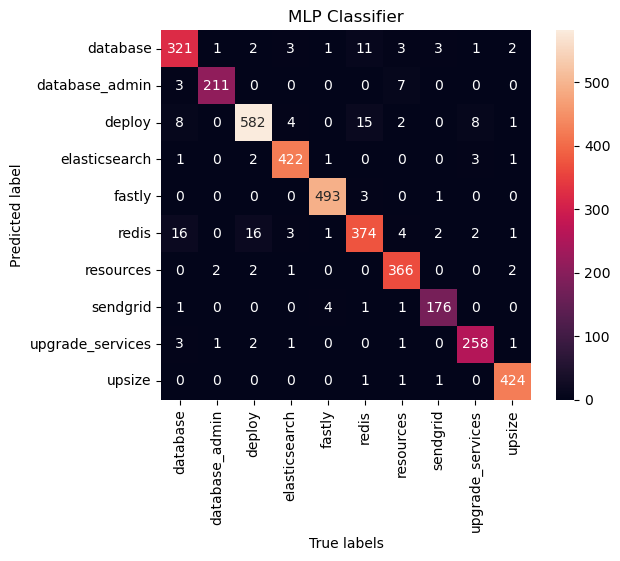

In [26]:
# Plot a confusion matrix
mat = confusion_matrix(ytest, preds)
sns.heatmap(mat.T, square = True, annot=True, fmt = "d", xticklabels=labels,yticklabels=labels)
plt.title('MLP Classifier')
plt.xlabel("True labels")
plt.ylabel("Predicted label")
plt.show()

In [27]:
# Generate a classification report
print('MLP Classifier, Test')
print(classification_report(ytest, preds))

MLP Classifier, Test
                  precision    recall  f1-score   support

        database       0.92      0.91      0.92       353
  database_admin       0.95      0.98      0.97       215
          deploy       0.94      0.96      0.95       606
   elasticsearch       0.98      0.97      0.98       434
          fastly       0.99      0.99      0.99       500
           redis       0.89      0.92      0.91       405
       resources       0.98      0.95      0.97       385
        sendgrid       0.96      0.96      0.96       183
upgrade_services       0.97      0.95      0.96       272
          upsize       0.99      0.98      0.99       432

        accuracy                           0.96      3785
       macro avg       0.96      0.96      0.96      3785
    weighted avg       0.96      0.96      0.96      3785



In [28]:
# Predict ytrain
preds = mdl.predict(vector_xtrain_us)

# Generate a classification report
print('MLP Classifier, Train')
print(classification_report(ytrain_us, preds))

MLP Classifier, Train
                  precision    recall  f1-score   support

        database       0.98      0.98      0.98       747
  database_admin       0.99      1.00      0.99       747
          deploy       0.97      0.99      0.98       747
   elasticsearch       1.00      1.00      1.00       747
          fastly       1.00      1.00      1.00       747
           redis       0.97      0.95      0.96       747
       resources       1.00      1.00      1.00       747
        sendgrid       1.00      0.99      1.00       747
upgrade_services       1.00      1.00      1.00       747
          upsize       1.00      1.00      1.00       747

        accuracy                           0.99      7470
       macro avg       0.99      0.99      0.99      7470
    weighted avg       0.99      0.99      0.99      7470



### Bagging Parameter Testing

In [ ]:
# Define relevant parameters to test
parameter_space = {'n_estimators':[],
                   'random_state': 0}

# Clarify model and its internal parameters
mdl = MLPClassifier(max_iter = 20000)

# Place bagger and parameters into GSCV
clf = GridSearchCV(BaggingClassifier(mdl),
                   parameter_space, n_jobs=-1, cv=5)

# Fit GSCV
clf.fit(vector_xtrain, ytrain)

# Produce best accuracy and parameters
print(f'Score: {clf.best_score_}')
print(f'Parameters: {clf.best_params_}')

### Bagging Model

In [41]:
%%time
# Define model and its internal parameters
mdl = MLPClassifier(random_state=0)

# Define bagger and its internal parameters
bg = BaggingClassifier(mdl,
                       random_state=0)

# Fit bagger
bg.fit(vector_xtrain_us, ytrain_us)

C:\Users\maxwe\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\maxwe\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\maxwe\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\maxwe\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\maxwe\anaconda3\Lib\site-packages\sklearn\neural_network\_multi

CPU times: total: 2min 30s
Wall time: 1min 22s


C:\Users\maxwe\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


BaggingClassifier(estimator=MLPClassifier(random_state=0), random_state=0)

In [42]:
%%time
# Predict
preds = bg.predict(vector_xtest)

CPU times: total: 125 ms
Wall time: 76.8 ms


In [43]:
# Store and export predictions
preds2 = pd.DataFrame(preds)
preds2.to_csv('mlp_preds_bg_us.csv', index=False)

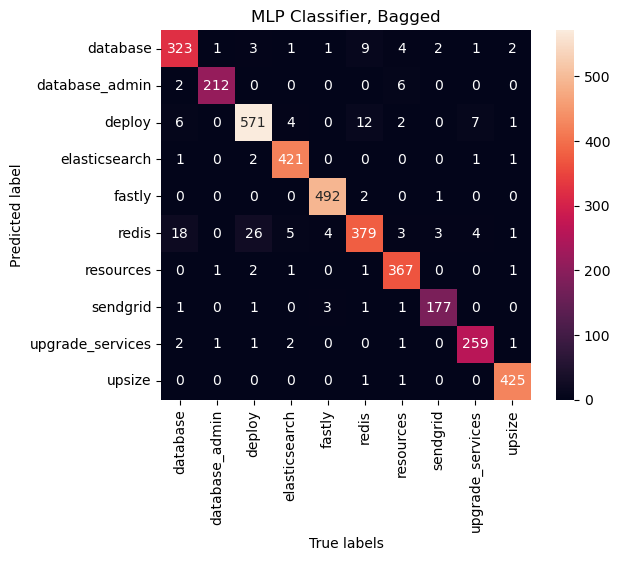

In [44]:
# Plot a confusion matrix
mat = confusion_matrix(ytest, preds)
sns.heatmap(mat.T, square = True, annot=True, fmt = "d", xticklabels=labels,yticklabels=labels)
plt.title('MLP Classifier, Bagged')
plt.xlabel("True labels")
plt.ylabel("Predicted label")
plt.show()

In [45]:
# Generate a classification report
print('MLP Classifier, Bagged, Test')
print(classification_report(ytest, preds))

MLP Classifier, Bagged, Test
                  precision    recall  f1-score   support

        database       0.93      0.92      0.92       353
  database_admin       0.96      0.99      0.97       215
          deploy       0.95      0.94      0.94       606
   elasticsearch       0.99      0.97      0.98       434
          fastly       0.99      0.98      0.99       500
           redis       0.86      0.94      0.89       405
       resources       0.98      0.95      0.97       385
        sendgrid       0.96      0.97      0.96       183
upgrade_services       0.97      0.95      0.96       272
          upsize       1.00      0.98      0.99       432

        accuracy                           0.96      3785
       macro avg       0.96      0.96      0.96      3785
    weighted avg       0.96      0.96      0.96      3785



In [46]:
# Predict ytrain
preds = bg.predict(vector_xtrain_us)

# Generate a classification report
print('MLP Classifier, Bagged, Train')
print(classification_report(ytrain_us, preds))

MLP Classifier, Bagged, Train
                  precision    recall  f1-score   support

        database       0.98      0.98      0.98       747
  database_admin       0.99      1.00      1.00       747
          deploy       0.98      0.99      0.98       747
   elasticsearch       0.99      1.00      0.99       747
          fastly       1.00      1.00      1.00       747
           redis       0.96      0.97      0.96       747
       resources       1.00      0.99      1.00       747
        sendgrid       1.00      0.99      1.00       747
upgrade_services       1.00      1.00      1.00       747
          upsize       1.00      1.00      1.00       747

        accuracy                           0.99      7470
       macro avg       0.99      0.99      0.99      7470
    weighted avg       0.99      0.99      0.99      7470



## Multinomial Logistic Regression (Lenin)
Parameters
* penalty (default 'l2'): penalty term
* dual (default False): dual or primal formulation; defaults to primal (regularized)
* tol (default 1e-4): tolerance for stopping criteria; float
* C (deault 1.0): inverse of regularization strength; positive float (small values have stronger regularization)
* fit_interpret (default True): specifies if a constant [intercept] should be added to the decision function; boolean
* intercept_scaling: NON-APPLICABLE
* class_weight (default None): weights associated w/ classes; dict, balanced, or None
* random_state (default None): control how the data is shuffled; applies to solvers sag, saga, and liblinear
* solver (default lbfgs): algorithm used; only newton-cg, sag, saga, and lbfgs apply
* max_iter (default 100): max iterations taken for solvers to converge; int
* multi_class: NON-APPLICABLE
* verbose: Unk
* warm_start (default False): if True, reuse solution of previous call to fit as initialization; boolean
* n_jobs (default None): number of CPU cores used when parallizing over classes; int, -1 means all cores used
* l1_ratio (default None): only used if elasticnet penalty is true; 0.5 does perfect balance of l1 and l2

In [66]:
# Multinomial Logistic Regression
from sklearn.linear_model import LogisticRegression

### Non-Ensemble Parameter Testing

In [ ]:
# Define relevant parameters to test
parameter_space = {'multi_class':'multinomial',}

# Clarify model
mdl = LogisticRegression()

# Place model and parameters into GSCV
clf = GridSearchCV(mdl, parameter_space, n_jobs=-1, cv=5)

# Fit GSCV
clf.fit(vector_xtrain, ytrain)

# Produce best accuracy and parameters
print(f'Score: {clf.best_score_}')
print(f'Parameters: {clf.best_params_}')

### Non-Ensemble Model

In [103]:
%%time
# Define the model and internal parameters
mdl = LogisticRegression(multi_class = 'multinomial', n_jobs=-1, random_state=0)

# Train the model
mdl.fit(vector_xtrain_us, ytrain_us)

CPU times: total: 15.6 ms
Wall time: 1.33 s


LogisticRegression(multi_class='multinomial', n_jobs=-1, random_state=0)

In [104]:
%%time
# Predict dependent variable for testing data
preds = mdl.predict(vector_xtest)

CPU times: total: 0 ns
Wall time: 4.06 ms


In [105]:
# Store and export predictions
preds2 = pd.DataFrame(preds)
preds2.to_csv('mlr_preds_us.csv', index=False)

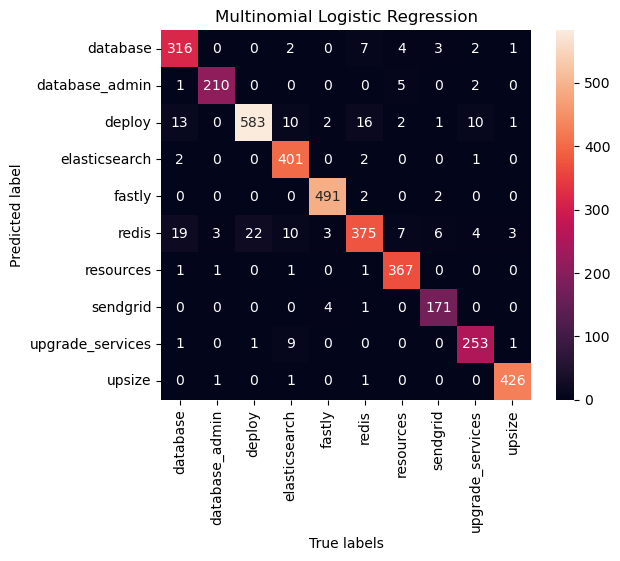

In [106]:
# Plot a confusion matrix
mat = confusion_matrix(ytest, preds)
sns.heatmap(mat.T, square = True, annot=True, fmt = "d", xticklabels=labels,yticklabels=labels)
plt.title('Multinomial Logistic Regression')
plt.xlabel("True labels")
plt.ylabel("Predicted label")
plt.show()

In [107]:
# Generate a classification report
print('Multinomial Logistic Regression, Test')
print(classification_report(ytest, preds))

Multinomial Logistic Regression, Test
                  precision    recall  f1-score   support

        database       0.94      0.90      0.92       353
  database_admin       0.96      0.98      0.97       215
          deploy       0.91      0.96      0.94       606
   elasticsearch       0.99      0.92      0.95       434
          fastly       0.99      0.98      0.99       500
           redis       0.83      0.93      0.88       405
       resources       0.99      0.95      0.97       385
        sendgrid       0.97      0.93      0.95       183
upgrade_services       0.95      0.93      0.94       272
          upsize       0.99      0.99      0.99       432

        accuracy                           0.95      3785
       macro avg       0.95      0.95      0.95      3785
    weighted avg       0.95      0.95      0.95      3785



In [108]:
# Predict ytrain
preds = mdl.predict(vector_xtrain_us)

# Generate a classification report
print('Multinomial Logistic Regression, Train')
print(classification_report(ytrain_us, preds))

Multinomial Logistic Regression, Train
                  precision    recall  f1-score   support

        database       0.95      0.91      0.93       747
  database_admin       0.98      0.95      0.96       747
          deploy       0.88      0.97      0.92       747
   elasticsearch       0.98      0.96      0.97       747
          fastly       0.99      0.97      0.98       747
           redis       0.85      0.90      0.88       747
       resources       0.98      0.96      0.97       747
        sendgrid       0.99      0.96      0.97       747
upgrade_services       0.97      0.97      0.97       747
          upsize       0.98      0.99      0.99       747

        accuracy                           0.95      7470
       macro avg       0.95      0.95      0.95      7470
    weighted avg       0.95      0.95      0.95      7470



### Bagging Parameter Testing

In [ ]:
# Define relevant parameters to test
parameter_space = {'n_estimators':[],
                   'random_state': 0}

# Clarify model and its internal parameters
mdl = LogisticRegression()

# Place bagger and parameters into GSCV
clf = GridSearchCV(BaggingClassifier(mdl),
                   parameter_space, n_jobs=-1, cv=5)

# Fit GSCV
clf.fit(vector_xtrain, ytrain)

# Produce best accuracy and parameters
print(f'Score: {clf.best_score_}')
print(f'Parameters: {clf.best_params_}')

### Bagging Model

In [109]:
%%time
# Define model and its internal parameters
mdl = LogisticRegression(multi_class = 'multinomial', n_jobs=-1, random_state=0)

# Define bagger and its internal parameters
bg = BaggingClassifier(mdl,
                       random_state=0)

# Fit bagger
bg.fit(vector_xtrain_us, ytrain_us)

CPU times: total: 93.8 ms
Wall time: 12.2 s


BaggingClassifier(estimator=LogisticRegression(multi_class='multinomial',
                                               n_jobs=-1, random_state=0),
                  random_state=0)

In [110]:
%%time
# Predict
preds = bg.predict(vector_xtest)

CPU times: total: 46.9 ms
Wall time: 32.2 ms


In [111]:
# Store and export predictions
preds2 = pd.DataFrame(preds)
preds2.to_csv('mlr_preds_us_bg.csv', index=False)

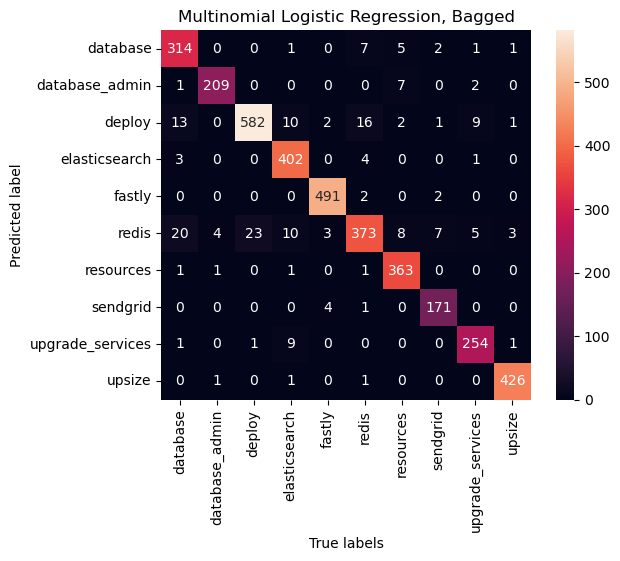

In [112]:
# Plot a confusion matrix
mat = confusion_matrix(ytest, preds)
sns.heatmap(mat.T, square = True, annot=True, fmt = "d", xticklabels=labels,yticklabels=labels)
plt.title('Multinomial Logistic Regression, Bagged')
plt.xlabel("True labels")
plt.ylabel("Predicted label")
plt.show()

In [113]:
# Generate a classification report
print('Multinomial Logistic Regression, Bagged, Test')
print(classification_report(ytest, preds))

Multinomial Logistic Regression, Bagged, Test
                  precision    recall  f1-score   support

        database       0.95      0.89      0.92       353
  database_admin       0.95      0.97      0.96       215
          deploy       0.92      0.96      0.94       606
   elasticsearch       0.98      0.93      0.95       434
          fastly       0.99      0.98      0.99       500
           redis       0.82      0.92      0.87       405
       resources       0.99      0.94      0.97       385
        sendgrid       0.97      0.93      0.95       183
upgrade_services       0.95      0.93      0.94       272
          upsize       0.99      0.99      0.99       432

        accuracy                           0.95      3785
       macro avg       0.95      0.94      0.95      3785
    weighted avg       0.95      0.95      0.95      3785



In [114]:
# Predict ytrain
preds = bg.predict(vector_xtrain_us)

# Generate a classification report
print('Multinomial Logistic Regression, Bagged, Train')
print(classification_report(ytrain_us, preds))

Multinomial Logistic Regression, Bagged, Train
                  precision    recall  f1-score   support

        database       0.95      0.91      0.93       747
  database_admin       0.98      0.95      0.96       747
          deploy       0.88      0.97      0.92       747
   elasticsearch       0.97      0.96      0.97       747
          fastly       0.99      0.97      0.98       747
           redis       0.85      0.90      0.87       747
       resources       0.98      0.96      0.97       747
        sendgrid       0.99      0.96      0.97       747
upgrade_services       0.97      0.97      0.97       747
          upsize       0.98      0.99      0.99       747

        accuracy                           0.95      7470
       macro avg       0.95      0.95      0.95      7470
    weighted avg       0.95      0.95      0.95      7470



### Boosting Parameter Testing

In [ ]:
# Define relevant parameters to test
parameter_space = {'n_estimators':,
                   'random_state': 0}

# Clarify model and its internal parameters
mdl = LogisticRegression(multi_class = 'multinomial')

# Place bagger and parameters into GSCV
clf = GridSearchCV(AdaBoostClassifier(mdl),
                   parameter_space, n_jobs=-1, cv=5)

# Fit GSCV
clf.fit(vector_xtrain, ytrain)

# Produce best accuracy and parameters
print(f'Score: {clf.best_score_}')
print(f'Parameters: {clf.best_params_}')

### Boosting Model

In [115]:
%%time
# Clarify model and its internal parameters
mdl = LogisticRegression(multi_class = 'multinomial', n_jobs=-1, random_state=0)

# Define booster and its internal parameters
bs = AdaBoostClassifier(mdl,
                        random_state = 0)

# Fit booster
bs.fit(vector_xtrain_us, ytrain_us)

CPU times: total: 13.2 s
Wall time: 55 s


AdaBoostClassifier(estimator=LogisticRegression(multi_class='multinomial',
                                                n_jobs=-1, random_state=0),
                   random_state=0)

In [116]:
%%time
# Generate predictions
preds = bs.predict(vector_xtest)

CPU times: total: 281 ms
Wall time: 183 ms


In [117]:
# Store and export predictions
preds2 = pd.DataFrame(preds)
preds2.to_csv('mlr_preds_us_bs.csv', index=False)

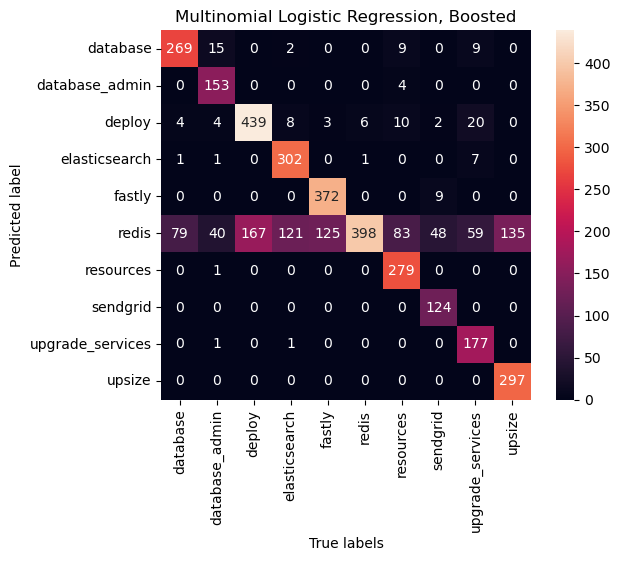

In [118]:
# Plot a confusion matrix
mat = confusion_matrix(ytest, preds)
sns.heatmap(mat.T, square = True, annot=True, fmt = "d", xticklabels=labels,yticklabels=labels)
plt.title('Multinomial Logistic Regression, Boosted')
plt.xlabel("True labels")
plt.ylabel("Predicted label")
plt.show()

In [119]:
# Generate a classification report
print('Multinomial Logistic Regression, Boosted, Test')
print(classification_report(ytest, preds))

Multinomial Logistic Regression, Boosted, Test
                  precision    recall  f1-score   support

        database       0.88      0.76      0.82       353
  database_admin       0.97      0.71      0.82       215
          deploy       0.89      0.72      0.80       606
   elasticsearch       0.97      0.70      0.81       434
          fastly       0.98      0.74      0.84       500
           redis       0.32      0.98      0.48       405
       resources       1.00      0.72      0.84       385
        sendgrid       1.00      0.68      0.81       183
upgrade_services       0.99      0.65      0.78       272
          upsize       1.00      0.69      0.81       432

        accuracy                           0.74      3785
       macro avg       0.90      0.74      0.78      3785
    weighted avg       0.89      0.74      0.78      3785



In [120]:
# Predict ytrain
preds = bs.predict(vector_xtrain_us)

# Generate a classification report
print('Multinomial Logistic Regression, Boosted, Train')
print(classification_report(ytrain_us, preds))

Multinomial Logistic Regression, Boosted, Train
                  precision    recall  f1-score   support

        database       0.85      0.76      0.80       747
  database_admin       0.98      0.68      0.80       747
          deploy       0.81      0.73      0.77       747
   elasticsearch       0.96      0.74      0.84       747
          fastly       0.94      0.72      0.82       747
           redis       0.31      0.98      0.47       747
       resources       0.99      0.73      0.84       747
        sendgrid       1.00      0.71      0.83       747
upgrade_services       0.99      0.69      0.81       747
          upsize       0.99      0.72      0.83       747

        accuracy                           0.74      7470
       macro avg       0.88      0.74      0.78      7470
    weighted avg       0.88      0.74      0.78      7470



## Multinomial Naive-Bayes (Pranitha)
Parameters
* alpha (default 1.0): additive smoothing parameter; float
* force_alpha (default True): forces alpha value if it is below 1e-10; boolean
* fit_prior (default True): whether to learn class prior probabilities or not. If false, a uniform prior will be used; boolean
* class_prior (default None): prior probabilities of the classes. If specified, the priors are not adjusted according to the data; array

In [121]:
# Multinomial Naive-Bayes
from sklearn.naive_bayes import MultinomialNB

### Non-Ensemble Parameter Testing

In [140]:
# Define relevant parameters to test
parameter_space = {'alpha':[],
                   'force_alpha':[],
                   'fit_prior':[],
                   'class_prior':[]}

# Clarify model
mdl = MultinomialNB()

# Place model and parameters into GSCV
clf = GridSearchCV(mdl, parameter_space, n_jobs=-1, cv=5)

# Fit GSCV
clf.fit(vector_xtrain, ytrain)

# Produce best accuracy and parameters
print(f'Score: {clf.best_score_}')
print(f'Parameters: {clf.best_params_}')

ValueError: Parameter grid for parameter 'alpha' need to be a non-empty sequence, got: []

### Non-Ensemble Model

In [159]:
%%time
# Define the model and internal parameters
mdl = MultinomialNB()

# Train the model
mdl.fit(vector_xtrain_us, ytrain_us)

CPU times: total: 15.6 ms
Wall time: 25.8 ms


MultinomialNB()

In [160]:
%%time
# Predict dependent variable for testing data
preds = mdl.predict(vector_xtest)

CPU times: total: 0 ns
Wall time: 3.66 ms


In [161]:
# Store and export predictions
preds2 = pd.DataFrame(preds)
preds2.to_csv('mnb_preds_us.csv', index=False)

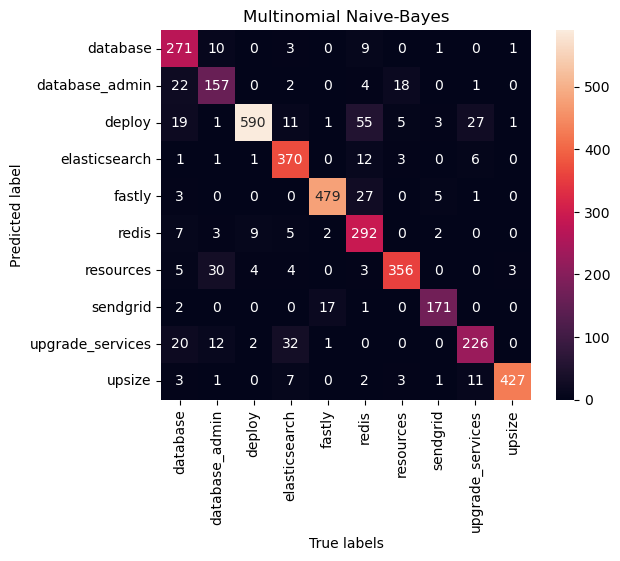

In [162]:
# Plot a confusion matrix
mat = confusion_matrix(ytest, preds)
sns.heatmap(mat.T, square = True, annot=True, fmt = "d", xticklabels=labels,yticklabels=labels)
plt.title('Multinomial Naive-Bayes')
plt.xlabel("True labels")
plt.ylabel("Predicted label")
plt.show()

In [163]:
# Generate a classification report
print('Multinomial Naive-Bayes, Test')
print(classification_report(ytest, preds))

Multinomial Naive-Bayes, Test
                  precision    recall  f1-score   support

        database       0.92      0.77      0.84       353
  database_admin       0.77      0.73      0.75       215
          deploy       0.83      0.97      0.89       606
   elasticsearch       0.94      0.85      0.89       434
          fastly       0.93      0.96      0.94       500
           redis       0.91      0.72      0.81       405
       resources       0.88      0.92      0.90       385
        sendgrid       0.90      0.93      0.91       183
upgrade_services       0.77      0.83      0.80       272
          upsize       0.94      0.99      0.96       432

        accuracy                           0.88      3785
       macro avg       0.88      0.87      0.87      3785
    weighted avg       0.89      0.88      0.88      3785



In [164]:
# Predict ytrain
preds = mdl.predict(vector_xtrain_us)

# Generate a classification report
print('Multinomial Naive-Bayes, Train')
print(classification_report(ytrain_us, preds))

Multinomial Naive-Bayes, Train
                  precision    recall  f1-score   support

        database       0.88      0.75      0.81       747
  database_admin       0.83      0.76      0.79       747
          deploy       0.73      0.97      0.83       747
   elasticsearch       0.92      0.84      0.88       747
          fastly       0.93      0.95      0.94       747
           redis       0.86      0.69      0.76       747
       resources       0.83      0.91      0.87       747
        sendgrid       0.96      0.94      0.95       747
upgrade_services       0.84      0.84      0.84       747
          upsize       0.91      0.98      0.95       747

        accuracy                           0.86      7470
       macro avg       0.87      0.86      0.86      7470
    weighted avg       0.87      0.86      0.86      7470



### Bagging Parameter Testing

In [ ]:
# Define relevant parameters to test
parameter_space = {'n_estimators':[],
                   'random_state': 0}

# Clarify model and its internal parameters
mdl = MultinomialNB()

# Place bagger and parameters into GSCV
clf = GridSearchCV(BaggingClassifier(mdl),
                   parameter_space, n_jobs=-1, cv=5)

# Fit GSCV
clf.fit(vector_xtrain, ytrain)

# Produce best accuracy and parameters
print(f'Score: {clf.best_score_}')
print(f'Parameters: {clf.best_params_}')

### Bagging Model

In [165]:
%%time
# Define model and its internal parameters
mdl = MultinomialNB()

# Define bagger and its internal parameters
bg = BaggingClassifier(mdl,
                       random_state=0)

# Fit bagger
bg.fit(vector_xtrain_us, ytrain_us)

CPU times: total: 109 ms
Wall time: 64.7 ms


BaggingClassifier(estimator=MultinomialNB(), random_state=0)

In [166]:
%%time
# Predict
preds = bg.predict(vector_xtest)

CPU times: total: 15.6 ms
Wall time: 36.9 ms


In [167]:
# Store and export predictions
preds2 = pd.DataFrame(preds)
preds2.to_csv('mnb_preds_us_bg.csv', index=False)

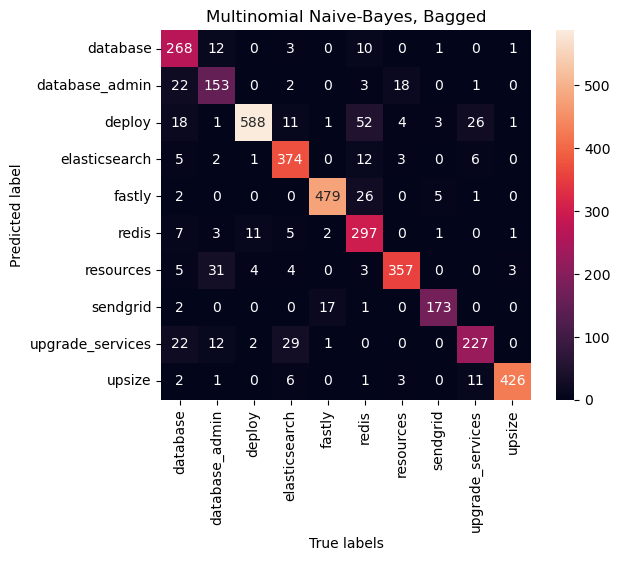

In [168]:
# Plot a confusion matrix
mat = confusion_matrix(ytest, preds)
sns.heatmap(mat.T, square = True, annot=True, fmt = "d", xticklabels=labels,yticklabels=labels)
plt.title('Multinomial Naive-Bayes, Bagged')
plt.xlabel("True labels")
plt.ylabel("Predicted label")
plt.show()

In [169]:
# Generate a classification report
print('Multinomial Naive-Bayes, Bagged, Test')
print(classification_report(ytest, preds))

Multinomial Naive-Bayes, Bagged, Test
                  precision    recall  f1-score   support

        database       0.91      0.76      0.83       353
  database_admin       0.77      0.71      0.74       215
          deploy       0.83      0.97      0.90       606
   elasticsearch       0.93      0.86      0.89       434
          fastly       0.93      0.96      0.95       500
           redis       0.91      0.73      0.81       405
       resources       0.88      0.93      0.90       385
        sendgrid       0.90      0.95      0.92       183
upgrade_services       0.77      0.83      0.80       272
          upsize       0.95      0.99      0.97       432

        accuracy                           0.88      3785
       macro avg       0.88      0.87      0.87      3785
    weighted avg       0.89      0.88      0.88      3785



In [170]:
# Predict ytrain
preds = bg.predict(vector_xtrain_us)

# Generate a classification report
print('Multinomial Naive-Bayes, Bagged, Train')
print(classification_report(ytrain_us, preds))

Multinomial Naive-Bayes, Bagged, Train
                  precision    recall  f1-score   support

        database       0.88      0.76      0.81       747
  database_admin       0.85      0.75      0.80       747
          deploy       0.74      0.98      0.84       747
   elasticsearch       0.90      0.86      0.88       747
          fastly       0.93      0.95      0.94       747
           redis       0.86      0.69      0.77       747
       resources       0.83      0.92      0.87       747
        sendgrid       0.96      0.94      0.95       747
upgrade_services       0.85      0.84      0.85       747
          upsize       0.91      0.98      0.94       747

        accuracy                           0.87      7470
       macro avg       0.87      0.87      0.87      7470
    weighted avg       0.87      0.87      0.87      7470



### Boosting Parameter Testing

In [ ]:
# Define relevant parameters to test
parameter_space = {'n_estimators':,
                   'random_state': 0}

# Clarify model and its internal parameters
mdl = MultinomialNB()

# Place bagger and parameters into GSCV
clf = GridSearchCV(AdaBoostClassifier(mdl),
                   parameter_space, n_jobs=-1, cv=5)

# Fit GSCV
clf.fit(vector_xtrain, ytrain)

# Produce best accuracy and parameters
print(f'Score: {clf.best_score_}')
print(f'Parameters: {clf.best_params_}')

### Boosting Model

In [171]:
%%time
# Clarify model and its internal parameters
mdl = MultinomialNB()

# Define booster and its internal parameters
bs = AdaBoostClassifier(mdl,
                        random_state = 0)

# Fit booster
bs.fit(vector_xtrain_us, ytrain_us)

CPU times: total: 2.22 s
Wall time: 1.89 s


AdaBoostClassifier(estimator=MultinomialNB(), random_state=0)

In [172]:
%%time
# Generate predictions
preds = bs.predict(vector_xtest)

CPU times: total: 109 ms
Wall time: 218 ms


In [173]:
# Store and export predictions
preds2 = pd.DataFrame(preds)
preds2.to_csv('mnb_preds_us_bs.csv', index=False)

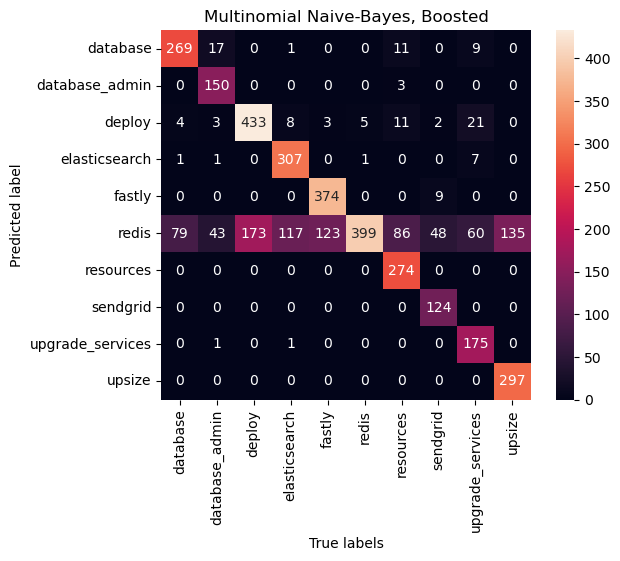

In [174]:
# Plot a confusion matrix
mat = confusion_matrix(ytest, preds)
sns.heatmap(mat.T, square = True, annot=True, fmt = "d", xticklabels=labels,yticklabels=labels)
plt.title('Multinomial Naive-Bayes, Boosted')
plt.xlabel("True labels")
plt.ylabel("Predicted label")
plt.show()

In [175]:
# Generate a classification report
print('Multinomial Naive-Bayes, Boosted, Test')
print(classification_report(ytest, preds))

Multinomial Naive-Bayes, Boosted, Test
                  precision    recall  f1-score   support

        database       0.88      0.76      0.82       353
  database_admin       0.98      0.70      0.82       215
          deploy       0.88      0.71      0.79       606
   elasticsearch       0.97      0.71      0.82       434
          fastly       0.98      0.75      0.85       500
           redis       0.32      0.99      0.48       405
       resources       1.00      0.71      0.83       385
        sendgrid       1.00      0.68      0.81       183
upgrade_services       0.99      0.64      0.78       272
          upsize       1.00      0.69      0.81       432

        accuracy                           0.74      3785
       macro avg       0.90      0.73      0.78      3785
    weighted avg       0.89      0.74      0.78      3785



In [176]:
# Predict ytrain
preds = bs.predict(vector_xtrain_us)

# Generate a classification report
print('Multinomial Naive-Bayes, Boosted, Train')
print(classification_report(ytrain_us, preds))

Multinomial Naive-Bayes, Boosted, Train
                  precision    recall  f1-score   support

        database       0.84      0.76      0.80       747
  database_admin       0.98      0.67      0.80       747
          deploy       0.82      0.73      0.77       747
   elasticsearch       0.96      0.74      0.84       747
          fastly       0.93      0.72      0.81       747
           redis       0.31      0.98      0.48       747
       resources       0.99      0.72      0.83       747
        sendgrid       1.00      0.70      0.82       747
upgrade_services       0.99      0.68      0.81       747
          upsize       0.99      0.71      0.83       747

        accuracy                           0.74      7470
       macro avg       0.88      0.74      0.78      7470
    weighted avg       0.88      0.74      0.78      7470



## Random Forest (Sharath)
Parameters
* n_estimators (default 100): # of trees in forest; int
* criterion (default 'gini'): function used to measure split quality; gini, entropy, or log_loss
* max_depth (default None): max depth of the tree; int
* min_samples_split (default 2): min samples needed to split a node; int or float [treated as fraction of n_samples]
* min_samples_leaf (default 1): min samples needed at a leaf node; int or float [treated as fraction of n_samples]
* min_weight_fraction_leaf (default 0.0): min weighted fraction of the sum of total weights of all input samples required at a leaf node; int. if 0, no weights given
* max_features (default 'sqrt'): # of features to consider when looking for best split; int, float [fraction], sqrt [sqrt of n_features], log2 [log2 of n_features], none [all features]
* max_leaf_nodes (default None): limit number of leaf nodes; int
* min_impurity_decrease (default = 0.0): node splits if impurity decrease >= this value; float
* bootstrap (default True): whether bootstrap samples used when building treed. If False, the whole dataset is used for each tree
* oob_score (default False): whether to use out-of-bag samples to estimate generalization score. if true, accuracy is used by default; boolean
* n_jobs (default = None): # of jobs to run in parallel; int, -1 = all processors
* random_state (defalut = None): control randomness of bootstrapping and feature sampling; int
* verbose (default 0): controls verbosity when fitting/predicting; int
* warm_start (default True): if True, reuse solution of previous call to fit and add more estimators to the ensemble; boolean
* class_weight (default None): weights associated with each class; balanced, balanced_subsample, dictionary, or None
* ccp_alpha (default 0.0): complexity parameter used for minimal cost-complexity pruning [subtree w/ largest cost complexity smaller than ccp_alpha will be chosen]; float
* max_samples (default None): number of samples to use in each tree if bootstrapped;; none, int, float [fraction]
* monotonic_cst (default None): NON-APPLICABLE

In [177]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

### Non-Ensemble Parameter Testing

In [ ]:
# Define relevant parameters to test
parameter_space = {'n_estimators':,
                   'random_state':0}

# Clarify model
mdl = RandomForestClassifier()

# Place model and parameters into GSCV
clf = GridSearchCV(mdl, parameter_space, n_jobs=-1, cv=5)

# Fit GSCV
clf.fit(vector_xtrain, ytrain)

# Produce best accuracy and parameters
print(f'Score: {clf.best_score_}')
print(f'Parameters: {clf.best_params_}')

### Non-Ensemble Model

In [214]:
%%time
# Define the model and internal parameters
mdl = RandomForestClassifier(random_state=0, n_jobs=-1)

# Train the model
mdl.fit(vector_xtrain_us, ytrain_us)

CPU times: total: 8.64 s
Wall time: 1.52 s


RandomForestClassifier(n_jobs=-1, random_state=0)

In [215]:
%%time
# Predict dependent variable for testing data
preds = mdl.predict(vector_xtest)

CPU times: total: 31.2 ms
Wall time: 84.7 ms


In [216]:
# Store and export predictions
preds2 = pd.DataFrame(preds)
preds2.to_csv('rf_preds_us.csv', index=False)

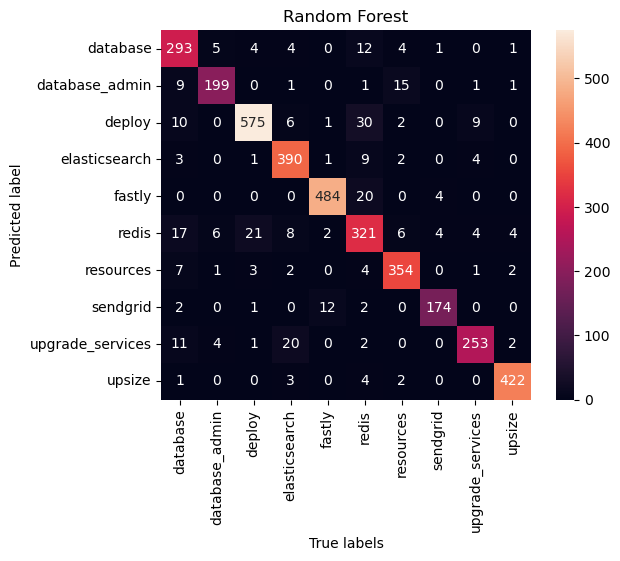

In [217]:
# Plot a confusion matrix
mat = confusion_matrix(ytest, preds)
sns.heatmap(mat.T, square = True, annot=True, fmt = "d", xticklabels=labels,yticklabels=labels)
plt.title('Random Forest')
plt.xlabel("True labels")
plt.ylabel("Predicted label")
plt.show()

In [218]:
# Generate a classification report
print('Random Forest, Test')
print(classification_report(ytest, preds))

Random Forest, Test
                  precision    recall  f1-score   support

        database       0.90      0.83      0.87       353
  database_admin       0.88      0.93      0.90       215
          deploy       0.91      0.95      0.93       606
   elasticsearch       0.95      0.90      0.92       434
          fastly       0.95      0.97      0.96       500
           redis       0.82      0.79      0.80       405
       resources       0.95      0.92      0.93       385
        sendgrid       0.91      0.95      0.93       183
upgrade_services       0.86      0.93      0.90       272
          upsize       0.98      0.98      0.98       432

        accuracy                           0.92      3785
       macro avg       0.91      0.91      0.91      3785
    weighted avg       0.92      0.92      0.92      3785



In [219]:
# Predict ytrain
preds = mdl.predict(vector_xtrain_us)

# Generate a classification report
print('Random Forest, Train')
print(classification_report(ytrain_us, preds))

Random Forest, Train
                  precision    recall  f1-score   support

        database       1.00      1.00      1.00       747
  database_admin       1.00      1.00      1.00       747
          deploy       1.00      1.00      1.00       747
   elasticsearch       1.00      1.00      1.00       747
          fastly       1.00      1.00      1.00       747
           redis       1.00      1.00      1.00       747
       resources       1.00      1.00      1.00       747
        sendgrid       1.00      1.00      1.00       747
upgrade_services       1.00      1.00      1.00       747
          upsize       1.00      1.00      1.00       747

        accuracy                           1.00      7470
       macro avg       1.00      1.00      1.00      7470
    weighted avg       1.00      1.00      1.00      7470



### Bagging Parameter Testing

In [ ]:
# Define relevant parameters to test
parameter_space = {'n_estimators':[],
                   'random_state': 0}

# Clarify model and its internal parameters
mdl = RandomForestClassifier(random_state=0)

# Place bagger and parameters into GSCV
clf = GridSearchCV(BaggingClassifier(mdl),
                   parameter_space, n_jobs=-1, cv=5)

# Fit GSCV
clf.fit(vector_xtrain, ytrain)

# Produce best accuracy and parameters
print(f'Score: {clf.best_score_}')
print(f'Parameters: {clf.best_params_}')

### Bagging Model

In [220]:
%%time
# Define model and its internal parameters
mdl = RandomForestClassifier(random_state=0, n_jobs=-1)

# Define bagger and its internal parameters
bg = BaggingClassifier(mdl,
                       random_state=0)

# Fit bagger
bg.fit(vector_xtrain_us, ytrain_us)

CPU times: total: 2.17 s
Wall time: 13 s


BaggingClassifier(estimator=RandomForestClassifier(n_jobs=-1, random_state=0),
                  random_state=0)

In [221]:
%%time
# Predict
preds = bg.predict(vector_xtest)

CPU times: total: 219 ms
Wall time: 859 ms


In [222]:
# Store and export predictions
preds2 = pd.DataFrame(preds)
preds2.to_csv('rf_preds_us_bg.csv', index=False)

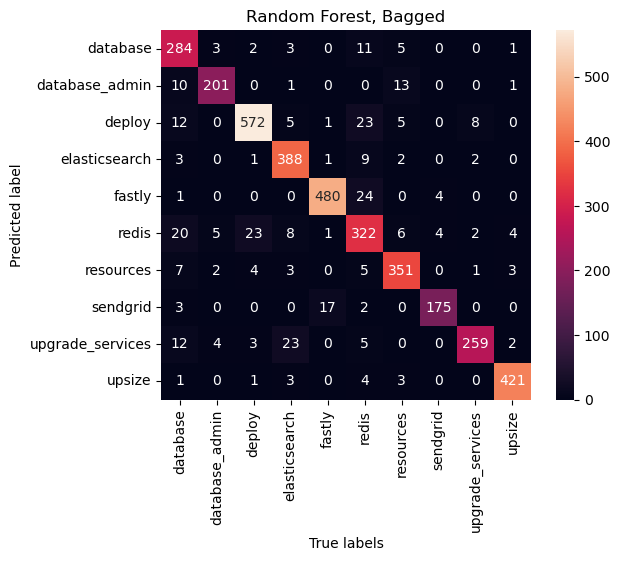

In [223]:
# Plot a confusion matrix
mat = confusion_matrix(ytest, preds)
sns.heatmap(mat.T, square = True, annot=True, fmt = "d", xticklabels=labels,yticklabels=labels)
plt.title('Random Forest, Bagged')
plt.xlabel("True labels")
plt.ylabel("Predicted label")
plt.show()

In [224]:
# Generate a classification report
print('Random Forest, Bagged, Test')
print(classification_report(ytest, preds))

Random Forest, Bagged, Test
                  precision    recall  f1-score   support

        database       0.92      0.80      0.86       353
  database_admin       0.89      0.93      0.91       215
          deploy       0.91      0.94      0.93       606
   elasticsearch       0.96      0.89      0.92       434
          fastly       0.94      0.96      0.95       500
           redis       0.82      0.80      0.81       405
       resources       0.93      0.91      0.92       385
        sendgrid       0.89      0.96      0.92       183
upgrade_services       0.84      0.95      0.89       272
          upsize       0.97      0.97      0.97       432

        accuracy                           0.91      3785
       macro avg       0.91      0.91      0.91      3785
    weighted avg       0.91      0.91      0.91      3785



In [225]:
# Predict ytrain
preds = bg.predict(vector_xtrain_us)

# Generate a classification report
print('Random Forest, Bagged, Train')
print(classification_report(ytrain_us, preds))

Random Forest, Bagged, Train
                  precision    recall  f1-score   support

        database       1.00      1.00      1.00       747
  database_admin       1.00      1.00      1.00       747
          deploy       0.99      1.00      1.00       747
   elasticsearch       1.00      1.00      1.00       747
          fastly       0.99      1.00      1.00       747
           redis       1.00      0.99      0.99       747
       resources       1.00      1.00      1.00       747
        sendgrid       1.00      1.00      1.00       747
upgrade_services       1.00      0.99      1.00       747
          upsize       1.00      1.00      1.00       747

        accuracy                           1.00      7470
       macro avg       1.00      1.00      1.00      7470
    weighted avg       1.00      1.00      1.00      7470



### Boosting Parameter Testing

In [ ]:
# Define relevant parameters to test
parameter_space = {'n_estimators':,
                   'random_state': 0}

# Clarify model and its internal parameters
mdl = RandomForestClassifier(random_state=0)

# Place bagger and parameters into GSCV
clf = GridSearchCV(AdaBoostClassifier(mdl),
                   parameter_space, n_jobs=-1, cv=5)

# Fit GSCV
clf.fit(vector_xtrain, ytrain)

# Produce best accuracy and parameters
print(f'Score: {clf.best_score_}')
print(f'Parameters: {clf.best_params_}')

### Boosting Model

In [226]:
%%time
# Clarify model and its internal parameters
mdl = RandomForestClassifier(random_state=0, n_jobs=-1)

# Define booster and its internal parameters
bs = AdaBoostClassifier(mdl,
                        random_state = 0)

# Fit booster
bs.fit(vector_xtrain_us, ytrain_us)

CPU times: total: 6.86 s
Wall time: 1.51 s


AdaBoostClassifier(estimator=RandomForestClassifier(n_jobs=-1, random_state=0),
                   random_state=0)

In [227]:
%%time
# Generate predictions
preds = bs.predict(vector_xtest)

CPU times: total: 15.6 ms
Wall time: 113 ms


In [228]:
# Store and export predictions
preds2 = pd.DataFrame(preds)
preds2.to_csv('rf_preds_us_bs.csv', index=False)

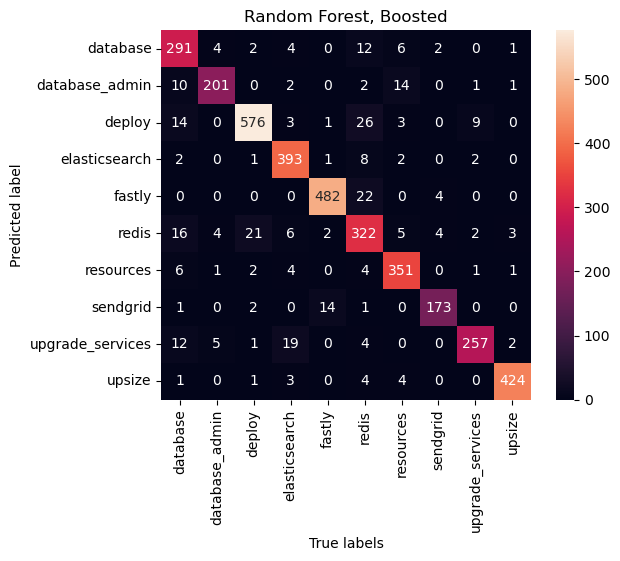

In [229]:
# Plot a confusion matrix
mat = confusion_matrix(ytest, preds)
sns.heatmap(mat.T, square = True, annot=True, fmt = "d", xticklabels=labels,yticklabels=labels)
plt.title('Random Forest, Boosted')
plt.xlabel("True labels")
plt.ylabel("Predicted label")
plt.show()

In [230]:
# Generate a classification report
print('Random Forest, Boosted, Test')
print(classification_report(ytest, preds))

Random Forest, Boosted, Test
                  precision    recall  f1-score   support

        database       0.90      0.82      0.86       353
  database_admin       0.87      0.93      0.90       215
          deploy       0.91      0.95      0.93       606
   elasticsearch       0.96      0.91      0.93       434
          fastly       0.95      0.96      0.96       500
           redis       0.84      0.80      0.82       405
       resources       0.95      0.91      0.93       385
        sendgrid       0.91      0.95      0.93       183
upgrade_services       0.86      0.94      0.90       272
          upsize       0.97      0.98      0.98       432

        accuracy                           0.92      3785
       macro avg       0.91      0.92      0.91      3785
    weighted avg       0.92      0.92      0.92      3785



In [231]:
# Predict ytrain
preds = bs.predict(vector_xtrain_us)

# Generate a classification report
print('Random Forest, Boosted, Train')
print(classification_report(ytrain_us, preds))

Random Forest, Boosted, Train
                  precision    recall  f1-score   support

        database       1.00      1.00      1.00       747
  database_admin       1.00      1.00      1.00       747
          deploy       1.00      1.00      1.00       747
   elasticsearch       1.00      1.00      1.00       747
          fastly       1.00      1.00      1.00       747
           redis       1.00      1.00      1.00       747
       resources       1.00      1.00      1.00       747
        sendgrid       1.00      1.00      1.00       747
upgrade_services       1.00      1.00      1.00       747
          upsize       1.00      1.00      1.00       747

        accuracy                           1.00      7470
       macro avg       1.00      1.00      1.00      7470
    weighted avg       1.00      1.00      1.00      7470



## Support Vector Machines - Linear (Lalita)
Parameters
* penalty (default='l2') - Specifies norm used in penaltization; l1 or l2
* loss (default='squared_hinge') = specifies loss function; 'hinge' or 'squared_hinge'
* dual (default='True') - solve either a dual or primal optimization problem. SET THIS TO 'FALSE'
* tol (default=1e-4) - tolerance for stopping criteria; float
* C (default=1.0) - regularization parameter. strength of regularization inversely proportional to C. must be positive; float
* multi_class (default 'ovr') Stick to 'ovr'
* fit_intercept (default True) - whether or not to fit an intercept; True or False
* intercept_scaling (default 1.0) - if fit_intercept is True, an intercept with a value of 'intercept_scaling' is added. higher values become less regularized; float
* class_weight (default None) - adds weights to each of your classes; custom defined through dictionary, 'balanced' [auto-balance weights], or None [no blancing; all weighted to 1]
* verbose (default 0) - enable verbose input; probably keep at 0
* random_state (default None) - controls randomness within the model; because we are using dual=False, we can keep this parameter set to None
* max_iter (default 1000) - max number of iterations that can be run; int

In [232]:
# SVM
from sklearn.svm import LinearSVC

### Non-Ensemble Parameter Testing

In [ ]:
# Define relevant parameters to test
parameter_space = {'dual':False,}

# Clarify model
mdl = LinearSVC()

# Place model and parameters into GSCV
clf = GridSearchCV(mdl, parameter_space, n_jobs=-1, cv=5)

# Fit GSCV
clf.fit(vector_xtrain, ytrain)

# Produce best accuracy and parameters
print(f'Score: {clf.best_score_}')
print(f'Parameters: {clf.best_params_}')

### Non-Ensemble Model

In [271]:
%%time
# Define the model and internal parameters
mdl = LinearSVC(dual=False, random_state=0)

# Train the model
mdl.fit(vector_xtrain_us, ytrain_us)

CPU times: total: 141 ms
Wall time: 190 ms


LinearSVC(dual=False, random_state=0)

In [272]:
%%time
# Predict dependent variable for testing data
preds = mdl.predict(vector_xtest)

CPU times: total: 0 ns
Wall time: 4.8 ms


In [273]:
# Store and export predictions
preds2 = pd.DataFrame(preds)
preds2.to_csv('svm_preds_us.csv', index=False)

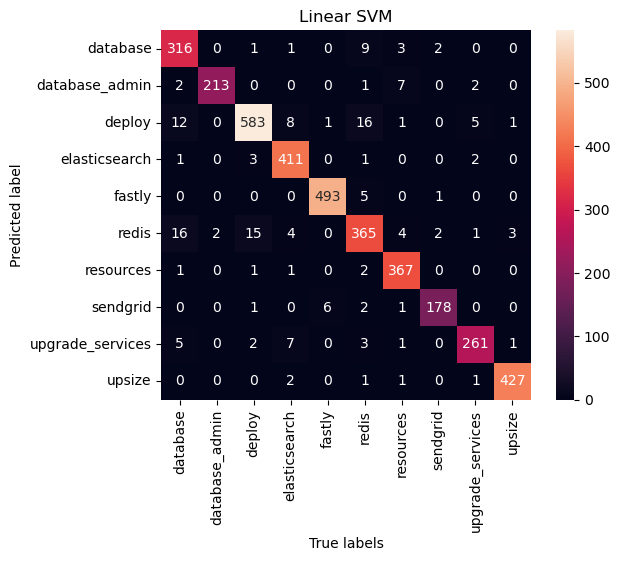

In [274]:
# Plot a confusion matrix
mat = confusion_matrix(ytest, preds)
sns.heatmap(mat.T, square = True, annot=True, fmt = "d", xticklabels=labels,yticklabels=labels)
plt.title('Linear SVM')
plt.xlabel("True labels")
plt.ylabel("Predicted label")
plt.show()

In [275]:
# Generate a classification report
print('Linear SVM, Test')
print(classification_report(ytest, preds))

Linear SVM, Test
                  precision    recall  f1-score   support

        database       0.95      0.90      0.92       353
  database_admin       0.95      0.99      0.97       215
          deploy       0.93      0.96      0.95       606
   elasticsearch       0.98      0.95      0.96       434
          fastly       0.99      0.99      0.99       500
           redis       0.89      0.90      0.89       405
       resources       0.99      0.95      0.97       385
        sendgrid       0.95      0.97      0.96       183
upgrade_services       0.93      0.96      0.95       272
          upsize       0.99      0.99      0.99       432

        accuracy                           0.95      3785
       macro avg       0.95      0.96      0.95      3785
    weighted avg       0.96      0.95      0.95      3785



In [276]:
# Predict ytrain
preds = mdl.predict(vector_xtrain_us)

# Generate a classification report
print('Linear SVM, Train')
print(classification_report(ytrain_us, preds))

Linear SVM, Train
                  precision    recall  f1-score   support

        database       0.96      0.93      0.94       747
  database_admin       0.97      0.98      0.97       747
          deploy       0.92      0.96      0.94       747
   elasticsearch       0.98      0.97      0.97       747
          fastly       0.99      0.98      0.98       747
           redis       0.93      0.90      0.91       747
       resources       0.98      0.98      0.98       747
        sendgrid       0.98      0.99      0.99       747
upgrade_services       0.96      0.98      0.97       747
          upsize       0.98      1.00      0.99       747

        accuracy                           0.97      7470
       macro avg       0.97      0.97      0.97      7470
    weighted avg       0.97      0.97      0.97      7470



### Bagging Parameter Testing

In [ ]:
# Define relevant parameters to test
parameter_space = {'n_estimators':[],
                   'random_state': 0}

# Clarify model and its internal parameters
mdl = LinearSVC(dual=False)

# Place bagger and parameters into GSCV
clf = GridSearchCV(BaggingClassifier(mdl),
                   parameter_space, n_jobs=-1, cv=5)

# Fit GSCV
clf.fit(vector_xtrain, ytrain)

# Produce best accuracy and parameters
print(f'Score: {clf.best_score_}')
print(f'Parameters: {clf.best_params_}')

### Bagging Model

In [277]:
%%time
# Define model and its internal parameters
mdl = LinearSVC(dual=False, random_state=0)

# Define bagger and its internal parameters
bg = BaggingClassifier(mdl,
                       random_state=0)

# Fit bagger
bg.fit(vector_xtrain_us, ytrain_us)

CPU times: total: 703 ms
Wall time: 1.24 s


BaggingClassifier(estimator=LinearSVC(dual=False, random_state=0),
                  random_state=0)

In [278]:
%%time
# Predict
preds = bg.predict(vector_xtest)

CPU times: total: 172 ms
Wall time: 88.6 ms


In [279]:
# Store and export predictions
preds2 = pd.DataFrame(preds)
preds2.to_csv('svm_preds_us_bg.csv', index=False)

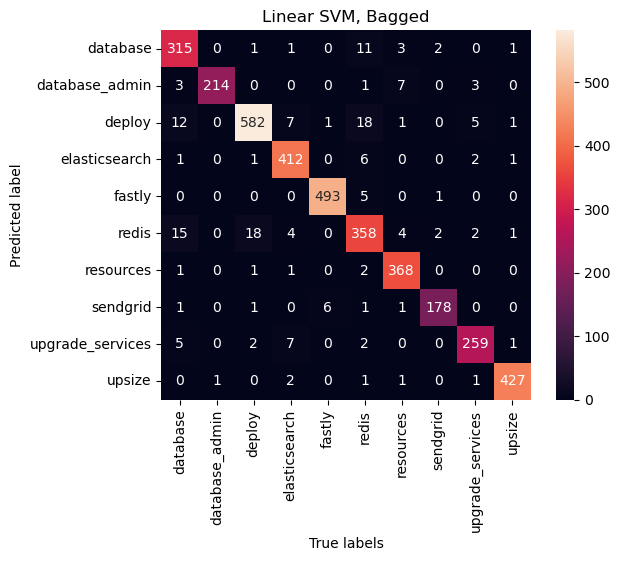

In [280]:
# Plot a confusion matrix
mat = confusion_matrix(ytest, preds)
sns.heatmap(mat.T, square = True, annot=True, fmt = "d", xticklabels=labels,yticklabels=labels)
plt.title('Linear SVM, Bagged')
plt.xlabel("True labels")
plt.ylabel("Predicted label")
plt.show()

In [281]:
# Generate a classification report
print('Linear SVM, Bagged, Test')
print(classification_report(ytest, preds))

Linear SVM, Bagged, Test
                  precision    recall  f1-score   support

        database       0.94      0.89      0.92       353
  database_admin       0.94      1.00      0.97       215
          deploy       0.93      0.96      0.94       606
   elasticsearch       0.97      0.95      0.96       434
          fastly       0.99      0.99      0.99       500
           redis       0.89      0.88      0.89       405
       resources       0.99      0.96      0.97       385
        sendgrid       0.95      0.97      0.96       183
upgrade_services       0.94      0.95      0.95       272
          upsize       0.99      0.99      0.99       432

        accuracy                           0.95      3785
       macro avg       0.95      0.95      0.95      3785
    weighted avg       0.95      0.95      0.95      3785



In [282]:
# Predict ytrain
preds = bg.predict(vector_xtrain_us)

# Generate a classification report
print('Linear SVM, Bagged, Train')
print(classification_report(ytrain_us, preds))

Linear SVM, Bagged, Train
                  precision    recall  f1-score   support

        database       0.95      0.93      0.94       747
  database_admin       0.97      0.98      0.98       747
          deploy       0.92      0.97      0.94       747
   elasticsearch       0.98      0.97      0.97       747
          fastly       0.99      0.98      0.98       747
           redis       0.93      0.89      0.91       747
       resources       0.98      0.97      0.98       747
        sendgrid       0.99      0.99      0.99       747
upgrade_services       0.96      0.98      0.97       747
          upsize       0.98      1.00      0.99       747

        accuracy                           0.97      7470
       macro avg       0.97      0.97      0.96      7470
    weighted avg       0.97      0.97      0.96      7470



### Boosting Parameter Testing

In [ ]:
# Define relevant parameters to test
parameter_space = {'n_estimators':,
                   'random_state': 0}

# Clarify model and its internal parameters
mdl = LinearSVC(dual=False)

# Place bagger and parameters into GSCV
clf = GridSearchCV(AdaBoostClassifier(mdl),
                   parameter_space, n_jobs=-1, cv=5)

# Fit GSCV
clf.fit(vector_xtrain, ytrain)

# Produce best accuracy and parameters
print(f'Score: {clf.best_score_}')
print(f'Parameters: {clf.best_params_}')

### Boosting Model

In [283]:
%%time
# Clarify model and its internal parameters
mdl = LinearSVC(dual=False, random_state=0)

# Define booster and its internal parameters
bs = AdaBoostClassifier(mdl,
                        random_state = 0,
                        algorithm='SAMME')

# Fit booster
bs.fit(vector_xtrain_us, ytrain_us)

CPU times: total: 8.98 s
Wall time: 6.64 s


AdaBoostClassifier(algorithm='SAMME',
                   estimator=LinearSVC(dual=False, random_state=0),
                   random_state=0)

In [284]:
%%time
# Generate predictions
preds = bs.predict(vector_xtest)

CPU times: total: 125 ms
Wall time: 211 ms


In [285]:
# Store and export predictions
preds2 = pd.DataFrame(preds)
preds2.to_csv('svm_preds_us_bs.csv', index=False)

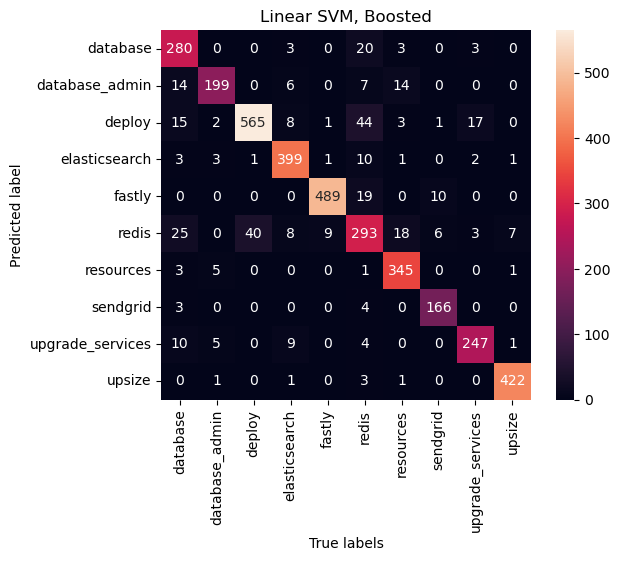

In [286]:
# Plot a confusion matrix
mat = confusion_matrix(ytest, preds)
sns.heatmap(mat.T, square = True, annot=True, fmt = "d", xticklabels=labels,yticklabels=labels)
plt.title('Linear SVM, Boosted')
plt.xlabel("True labels")
plt.ylabel("Predicted label")
plt.show()

In [287]:
# Generate a classification report
print('Linear SVM, Boosted, Test')
print(classification_report(ytest, preds))

Linear SVM, Boosted, Test
                  precision    recall  f1-score   support

        database       0.91      0.79      0.85       353
  database_admin       0.83      0.93      0.87       215
          deploy       0.86      0.93      0.90       606
   elasticsearch       0.95      0.92      0.93       434
          fastly       0.94      0.98      0.96       500
           redis       0.72      0.72      0.72       405
       resources       0.97      0.90      0.93       385
        sendgrid       0.96      0.91      0.93       183
upgrade_services       0.89      0.91      0.90       272
          upsize       0.99      0.98      0.98       432

        accuracy                           0.90      3785
       macro avg       0.90      0.90      0.90      3785
    weighted avg       0.90      0.90      0.90      3785



In [288]:
# Predict ytrain
preds = bs.predict(vector_xtrain_us)

# Generate a classification report
print('Linear SVM, Boosted, Train')
print(classification_report(ytrain_us, preds))

Linear SVM, Boosted, Train
                  precision    recall  f1-score   support

        database       0.91      0.81      0.86       747
  database_admin       0.88      0.93      0.90       747
          deploy       0.81      0.93      0.87       747
   elasticsearch       0.93      0.96      0.94       747
          fastly       0.92      0.96      0.94       747
           redis       0.71      0.71      0.71       747
       resources       0.95      0.86      0.90       747
        sendgrid       0.98      0.92      0.95       747
upgrade_services       0.95      0.91      0.93       747
          upsize       0.98      0.96      0.97       747

        accuracy                           0.90      7470
       macro avg       0.90      0.90      0.90      7470
    weighted avg       0.90      0.90      0.90      7470



# Voting Classifier

In [289]:
from sklearn.ensemble import VotingClassifier

In [319]:
# Create estimator list
estimator = []

# Add estimators to the list
estimator.append(('MLP', MLPClassifier(random_state=0)))
estimator.append(('SVM', LinearSVC(dual=False, random_state=0)))
estimator.append(('MLR', LogisticRegression(multi_class='multinomial', n_jobs=-1,random_state=0)))

## Hard Voting

In [320]:
%%time
# Define the voter
hardvote=VotingClassifier(estimators=estimator,voting='hard')

# Fit the voter
hardvote.fit(vector_xtrain,ytrain)

C:\Users\maxwe\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


CPU times: total: 1min 22s
Wall time: 59.9 s


VotingClassifier(estimators=[('MLP', MLPClassifier(random_state=0)),
                             ('SVM', LinearSVC(dual=False, random_state=0)),
                             ('MLR',
                              LogisticRegression(multi_class='multinomial',
                                                 n_jobs=-1, random_state=0))])

In [321]:
%%time
# Generate predictions
preds = hardvote.predict(vector_xtest)

CPU times: total: 46.9 ms
Wall time: 82.3 ms


In [322]:
# Store and export predictions
preds2 = pd.DataFrame(preds)
preds2.to_csv('hardvote_2.csv', index=False)

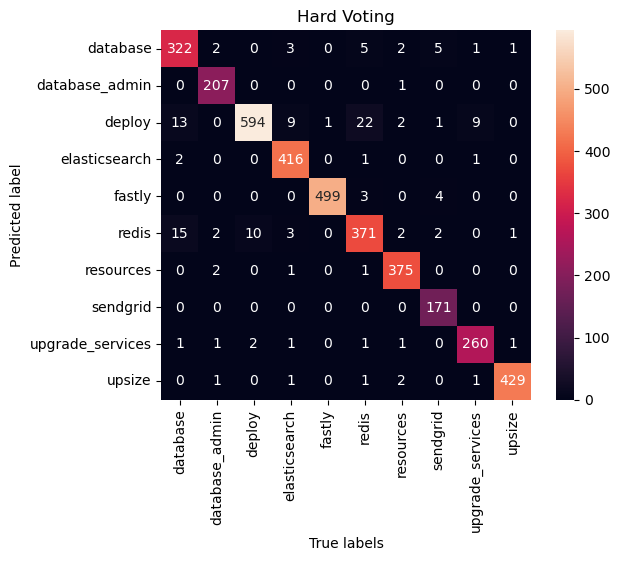

In [323]:
# Plot a confusion matrix
mat = confusion_matrix(ytest, preds)
sns.heatmap(mat.T, square = True, annot=True, fmt = "d", xticklabels=labels,yticklabels=labels)
plt.title('Hard Voting')
plt.xlabel("True labels")
plt.ylabel("Predicted label")
plt.show()

In [324]:
# Generate a classification report
print('Hard Voting, Test')
print(classification_report(ytest, preds))

Hard Voting, Test
                  precision    recall  f1-score   support

        database       0.94      0.91      0.93       353
  database_admin       1.00      0.96      0.98       215
          deploy       0.91      0.98      0.95       606
   elasticsearch       0.99      0.96      0.97       434
          fastly       0.99      1.00      0.99       500
           redis       0.91      0.92      0.91       405
       resources       0.99      0.97      0.98       385
        sendgrid       1.00      0.93      0.97       183
upgrade_services       0.97      0.96      0.96       272
          upsize       0.99      0.99      0.99       432

        accuracy                           0.96      3785
       macro avg       0.97      0.96      0.96      3785
    weighted avg       0.96      0.96      0.96      3785



In [325]:
# Predict ytrain
preds = hardvote.predict(vector_xtrain)

# Generate a classification report
print('Hard Voting, Train')
print(classification_report(ytrain, preds))

Hard Voting, Train
                  precision    recall  f1-score   support

        database       0.96      0.93      0.95      1430
  database_admin       0.98      0.96      0.97       870
          deploy       0.93      0.99      0.96      2612
   elasticsearch       0.98      0.98      0.98      1704
          fastly       0.99      0.99      0.99      1794
           redis       0.93      0.89      0.91      1541
       resources       0.99      0.98      0.99      1554
        sendgrid       1.00      0.96      0.98       747
upgrade_services       0.98      0.97      0.98      1126
          upsize       0.99      1.00      0.99      1759

        accuracy                           0.97     15137
       macro avg       0.97      0.97      0.97     15137
    weighted avg       0.97      0.97      0.97     15137

